# Machine Learning pipeline

In this notebook, we go through the machine learning pipeline to reproduce Lydia Chougar's paper. The following sections will be covered:

[1. Convert CSV to DataFrame](#data)

[2. Normalize data](#normalize)

[3. Define models](#models)

[4. Training models](#training)

[5. Results](#results)

### Imports

In [1]:
import pandas as pd
import numpy as np
import glob, utils, sys, os, json
from bs4 import BeautifulSoup as bs

# Data

Converts data from CSV to DataFrame and applies any function. 
- "combine": sums all Left and Right regions into one column

In [2]:
def get_data(csvFileName: str, ROI: [], heuristic = None):
    '''
    The following function will sanitize data and build a numpy array with X ROI's volumes and y being the class [NC, PD]
    @csvFileName: input volumes csv
    @ROI: regions of interests desired
    @heuristic: function key
    '''
    df = pd.read_csv(csvFileName)
    df = utils.remove_unwanted_columns(df, ROI)
    
    if heuristic == "combine":
        df = utils.combine_left_right_vol(df)
        
    cols = list(df.columns.values)
    cols.pop(cols.index("subjectId"))
    df = df[["subjectId"]+cols]
    
    return df

Test *get_data()* function

In [3]:
ROI = [
      "subjectId", "class",
      "Left-Putamen", "Right-Putamen", 
      "Right-Caudate", "Left-Caudate", 
      "Right-Thalamus-Proper", "Left-Thalamus-Proper", 
      "Left-Pallidum", "Right-Pallidum", 
      "Left-Cerebellum-White-Matter", "Right-Cerebellum-White-Matter", 
      "Left-Cerebellum-Cortex", "Right-Cerebellum-Cortex",
      "3rd-Ventricle", 
      "4th-Ventricle"
]
df = get_data("volumes.csv", ROI, "combine")
# df = get_data("volumes.csv", ROI, "combine", getDf=True)
df

,subjectId,Pallidum,Putamen,Caudate,Cerebellum-Cortex,Cerebellum-White-Matter,3rd-Ventricle,4th-Ventricle,class
0,3572,3234.8,9403.7,6425.5,101202.1,25991.9,809.7,1595.2,NC
1,3756,4021.1,11431.6,8336.5,112507.9,27906.7,1677.0,3021.0,NC
2,3768,4240.4,9828.9,7275.3,108180.9,31634.3,2087.1,2487.0,NC
3,3369,3871.7,11068.1,7607.9,98919.4,27742.0,918.2,1360.3,NC
4,4004,3584.6,9379.7,5883.9,93553.2,25869.0,1374.2,2325.2,NC
...,...,...,...,...,...,...,...,...,...
210,3366,5022.9,9982.7,6595.5,105510.8,38319.9,1169.8,1489.1,PD
211,3367,4348.7,11044.1,6933.7,105346.1,31321.5,1101.7,1875.8,PD
212,3116,4310.3,9121.3,6645.2,101564.1,28589.7,1863.4,2550.6,PD
213,3587,4172.0,10429.8,8795.1,123481.9,28049.4,1282.8,2278.8,PD


# Normalize

In this section, normalization of the data using "Normalization 1" and "Normaliztion 2" techniques are implemented. 

Normalization 1:

$$\dfrac{Variable – mean \; of \;PD \;and \;NC \;in \;the \;training \;cohort}{\sigma \;of \;PD \;and \;NC \;in \;the \;training \;cohort}$$

Normalization 2:

$$\dfrac{Variable – mean \; of \;controls \;scanned \;using \;the \;same \;scanner}{\sigma \;of \;controls \;scanned \;using \;the \;same \;scanner}$$


In [4]:
def normalize1(df, mean, std):
    if mean is None and std is None:
        mean = df.mean(axis=0)
        std = df.std(axis=0)
        normalizedDf = (df - mean)/std
        return normalizedDf.values, mean, std

    normalizedDf = (df - mean)/std
    return normalizedDf.values

In [5]:
# Testing normalization1
trainDf = pd.DataFrame(np.array([[1, 2, 3], [3, 4, 7]]),columns=['a', 'b', 'c'])
testDf = pd.DataFrame(np.array([[2, 6, 4], [3, 7, 9]]),columns=['a', 'b', 'c'])
normTrainDf, trainMean, trainStd = normalize1(trainDf, None, None)
normTestDf = normalize1(testDf, trainMean, trainStd)
normTrainDf

array([[-0.70710678, -0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678,  0.70710678]])

In [6]:
def normalize2(df):
    df_no_id = df.drop(columns=["subjectId", "class"])
    metadata_df = utils.parse_metadata()
    merged_df = pd.merge(df, metadata_df, on=["subjectId"], how="left")
   
    stats = {}
    for scanner in merged_df["scannerType"].dropna().unique():
        mean, std = utils.get_mean_and_stats(merged_df.drop(columns="subjectId"), scanner, df_no_id.shape[1])
        stats[scanner] = {
            "mean": mean.to_dict(),
            "std": std.to_dict()
        }

    for index in merged_df.index:
        rowInfo = merged_df.iloc[index]
        scanner = rowInfo["scannerType"]
        mean = list(stats[scanner]["mean"].values())
        std = list(stats[scanner]["std"].values())
        df_no_id.iloc[index] = (df_no_id.iloc[index]-mean)/std
        
    return df_no_id

In [7]:
# Testing normalization2
df_norm2 = get_data("volumes.csv", ROI, "combine")
normalize2Df = normalize2(df_norm2)
normalize2Df

,Pallidum,Putamen,Caudate,Cerebellum-Cortex,Cerebellum-White-Matter,3rd-Ventricle,4th-Ventricle
0,-1.254627,0.027858,-0.489725,-0.341841,-0.731373,-1.033358,-0.373735
1,0.301883,2.070251,1.624695,0.607634,-0.196809,0.362490,1.738754
2,0.735996,0.456097,0.450533,0.244247,0.843845,1.022511,0.947571
3,0.006140,1.704153,0.818538,-0.533545,-0.242789,-0.858736,-0.721767
4,-0.562185,0.003687,-1.088977,-0.984206,-0.765684,-0.124842,0.707845
...,...,...,...,...,...,...,...
210,2.284984,0.610996,-0.301629,0.020009,2.710298,-0.453807,-0.530935
211,0.950380,1.679982,0.072571,0.006177,0.756519,-0.563408,0.042006
212,0.874365,-0.256560,-0.246639,-0.311440,-0.006132,0.662485,1.041801
213,0.600595,1.061291,2.132112,1.529245,-0.156970,-0.271943,0.639098


# Models

In this section, we define four models being logisitc regression, SVM with linear and radial kernel and a random forest. As per the paper:

_Using the scikit-learn package, four supervised
machine learning algorithms were used: logistic regression, support vector machine (SVM) with a linear kernel, SVM with a radial basis function kernel, and
random forest_ (Chougar et al.)

Additionally, we will implement a stratified cross validation loop for hyperparameter tuning. As per the paper:

_The cross-validation procedure on the training cohort included two nested loops: an outer loop with repeated stratified random splits with 50 repetitions evaluating the classification performances and an inner loop with 5 fold cross-validation used to optimize the hyperparameters of the algorithms_ (Chougar et al.)

### Imports

In [8]:
# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Utils
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Parallel job
from joblib import Parallel, delayed
import matplotlib.pyplot as plt


# SINGLE MODEL TEST - Tristan request

{'modelInfo': {'model': 'test_lr', 'normalization': 'Normalization 2'}, 'train': {'accuracy': 0.7133333333333334, 'f1_score': 0.8200836820083682, 'balanced_accuracy': 0.5741421568627452, 'auc': 0.5741421568627452, 'sensitivity': 0.9607843137254902, 'specificity': 0.1875}, 'test': {'accuracy': 0.7076923076923077, 'f1_score': 0.819047619047619, 'balanced_accuracy': 0.53, 'auc': 0.53, 'sensitivity': 0.86, 'specificity': 0.2}}


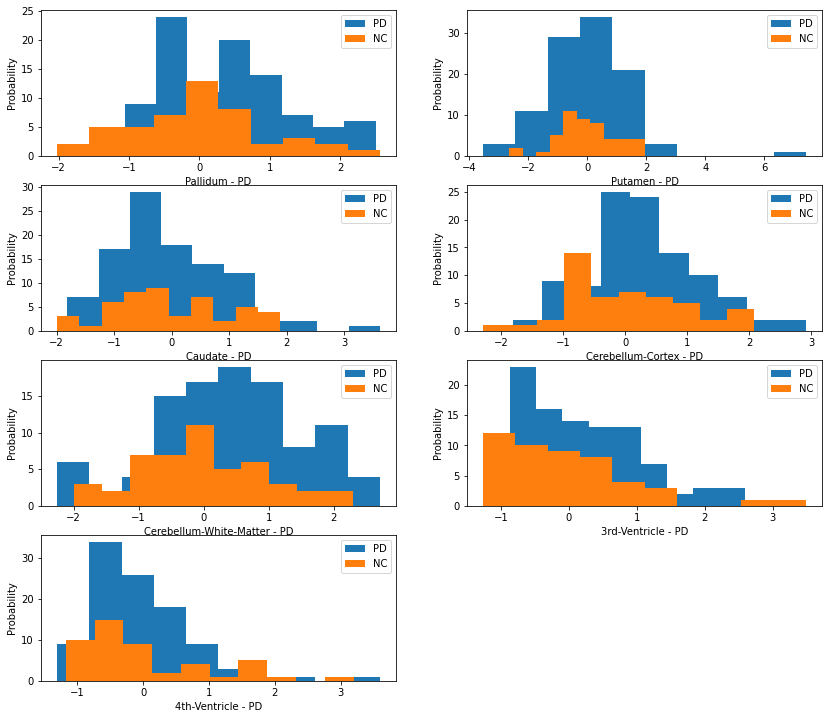

In [9]:
def performance_report(model, modelType, reportKey, X_train, X_test, y_train, y_test):
    performanceDict = {}
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_predict)
    test_accuracy = accuracy_score(y_test, y_test_predict)

    # F1
    train_f1 = f1_score(y_train, y_train_predict)
    test_f1 = f1_score(y_test, y_test_predict)

    # BA
    train_ba = balanced_accuracy_score(y_train, y_train_predict)
    test_ba = balanced_accuracy_score(y_test, y_test_predict)

    # ROC AUC
    train_auc = roc_auc_score(y_train, y_train_predict)
    test_auc = roc_auc_score(y_test, y_test_predict)
#     roc_plot = plot_roc_curve(model, X_test, y_test).figure.savefig(f"{modelType}/roc.png")

    # Sensitivity & Specificity
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_predict).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_predict).ravel()

    specificity_train = tn_train / (tn_train + fp_train)
    specificity_test = tn_test / (tn_test + fp_test)

    sensitivity_train = recall_score(y_train, y_train_predict)
    sensitivity_test = recall_score(y_test, y_test_predict)

    normalization = "Normalization 1" if reportKey.split("_")[-1] == "norm1" else "Normalization 2"
 
    modelInfo = {
        "model": modelType,
        "normalization": normalization
    }

    trainMetrics = {
        "accuracy": train_accuracy,
        "f1_score": train_f1,
        "balanced_accuracy": train_ba,
        "auc": train_auc,
        "sensitivity": sensitivity_train,
        "specificity": specificity_train
    }

    testMetrics = {
        "accuracy": test_accuracy,
        "f1_score": test_f1,
        "balanced_accuracy": test_ba,
        "auc": test_auc,
        "sensitivity": sensitivity_test,
        "specificity": specificity_test
    }

    performanceDict = {
        "modelInfo": modelInfo,
        "train": trainMetrics,
        "test": testMetrics
    }

    return performanceDict

def model_test(df, modelType, reportKey, normalize, dataFile, ROI, heuristic=None):
    X = df.values
    y = utils.convert_Y(df.values[:, -1])
    columns = df.columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    if normalize.__name__ == "normalize1":
        trainDf = pd.DataFrame(X_train, columns=columns).drop(columns=["subjectId", "class"])
        testDf = pd.DataFrame(X_test, columns=columns).drop(columns=["subjectId", "class"])
        X_train_normalized, mean_train, std_train = normalize(trainDf, None, None)
        X_test_normalized = normalize(testDf, mean_train, std_train)
    elif normalize.__name__ == "normalize2":
        trainDf = pd.DataFrame(X_train, columns=columns)
        testDf = pd.DataFrame(X_test, columns=columns)
        X_train_normalized = normalize2(trainDf)
        X_test_normalized = normalize2(testDf)
        
    PD_VAL = []
    NC_VAL = []
    fig = plt.figure(figsize=(14,22))
    counter = 1  # initialize plot counter
    for feature in columns[1:-1]:
        values = X_train_normalized[feature]
        for index, val in enumerate(values):
            if (y_train[index] == 1):
                PD_VAL.append(val)
            else:
                NC_VAL.append(val)              
        
        plt.subplot(7, 2, counter)
        plt.hist(PD_VAL, label='PD')
        plt.hist(NC_VAL, label='NC')
        plt.ylabel(f'Probability')
        plt.xlabel(f'{feature} - PD')
        plt.legend(loc='upper right')
        counter+=1
        
        # reset values
        PD_VAL = []
        NC_VAL = []
    
    clf = LogisticRegression(random_state=0)
    model = clf.fit(X_train_normalized, y_train)
    print(performance_report(model, modelType, reportKey, X_train_normalized, X_test_normalized, y_train, y_test))


model_test(df, "test_lr", "test_lr", normalize2, "volumes.csv", ROI, heuristic="combine")

### Generic definition

In [10]:
def model(df, modelType, reportKey, normalize, paramGrid, dataFile, ROI, heuristic=None):   
    print(f"\n======================Running {modelType} with the following parameters======================\nNormalization: {normalize.__name__}\nParam Grid: {paramGrid}\nData: {dataFile}\nROI: {ROI}")
    performanceDict = {}
    X = df.values
    y = utils.convert_Y(X[:, -1])
    columns = df.columns
    
    # Setup CV
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=50, random_state=42)
    
    # Define model type
    if modelType == "SVM":
        clf = GridSearchCV(SVC(random_state=0), paramGrid)
    elif modelType == "RF":
        clf = GridSearchCV(RandomForestClassifier(random_state=0), paramGrid)
    elif modelType == "LR":
        clf = GridSearchCV(LogisticRegression(random_state=0), paramGrid)
    
    iteration = 0
    for train_index, test_index in cv.split(X, y):        
        print(f"=================Iteration #{iteration}=================")
        
        # Get fold data train/test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(f'Shape of train set: {X_train.shape}')
        print(f'Shape of test set: {X_test.shape}')
        
        # Normalize model data
        print("Normalizing data...")
        if normalize.__name__ == "normalize1":
            trainDf = pd.DataFrame(X_train, columns=columns).drop(columns=["subjectId", "class"])
            testDf = pd.DataFrame(X_test, columns=columns).drop(columns=["subjectId", "class"])
            X_train_normalized, mean_train, std_train = normalize(trainDf, None, None)
            X_test_normalized = normalize(testDf, mean_train, std_train)

        elif normalize.__name__ == "normalize2":
            trainDf = pd.DataFrame(X_train, columns=columns)
            testDf = pd.DataFrame(X_test, columns=columns)
            X_train_normalized = normalize2(trainDf)
            X_test_normalized = normalize2(testDf)
            
        print("Done normalizing data")
            
        print("Fitting model...")
        model = clf.fit(X_train_normalized, y_train)
        print("Done fitting model")
        
        print("Computing results metrics...")
        utils.performance_report(performanceDict, model, modelType, reportKey, iteration, X_train_normalized, X_test_normalized, y_train, y_test)
        print("Done computing results metrics\n")
        iteration+=1
        
    with open(f"report.json", 'w', encoding='utf-8') as f:
        json.dump(performanceDict, f, ensure_ascii=False, indent=4)
        
    return performanceDict

### Parallel model

Since our cross validation loop produces 250 folds per model, it is bound to take a long time to run. Therefore, a refined version of the code above is re-written in parallel. 

It is recommended that you run the following code from your terminal:
```
conda activate research # Check README to get corect CONDA environemnt
cd ml/
python run.py
```

In [11]:
def train(clf, train_index, test_index, X, y, normalize, columns, modelType, reportKey, iteration):
    print(f"=================Iteration #{iteration}=================")
    performanceDict = {}
        
    # Get fold data train/test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(f'Shape of train set: {X_train.shape}')
    print(f'Shape of test set: {X_test.shape}')
    
    # Normalize model data
    print("Normalizing data...")
    if normalize.__name__ == "normalize1":
        trainDf = pd.DataFrame(X_train, columns=columns).drop(columns=["subjectId", "class"])
        testDf = pd.DataFrame(X_test, columns=columns).drop(columns=["subjectId", "class"])
        X_train_normalized, mean_train, std_train = normalize(trainDf, None, None)
        X_test_normalized = normalize(testDf, mean_train, std_train)

    elif normalize.__name__ == "normalize2":
        trainDf = pd.DataFrame(X_train, columns=columns)
        testDf = pd.DataFrame(X_test, columns=columns)
        X_train_normalized = normalize2(trainDf)
        X_test_normalized = normalize2(testDf)
        
    print("Done normalizing data")
        
    print(f"Fitting {modelType} model #{iteration}...")
    model = clf.fit(X_train_normalized, y_train)
    print("Done fitting model")
    
    print(f"Computing results metrics for {modelType} model #{iteration}...")
    performanceDict = utils.performance_report(model, modelType, reportKey, iteration, X_train_normalized, X_test_normalized, y_train, y_test)
    print("Done computing results metrics\n")

    return performanceDict

def parallel_model(df, modelType, reportKey, normalize, paramGrid, dataFile, ROI, heuristic=None):
    print(f"\n======================Running {modelType} with the following parameters======================\nNormalization: {normalize.__name__}\nParam Grid: {paramGrid}\nData: {dataFile}\nROI: {ROI}")

    performance = []
    if not os.path.isdir(modelType):
        os.mkdir(modelType)

    X = df.values
    y = utils.convert_Y(X[:, -1])
    columns = df.columns
    
    # Setup CV
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=42)

    # Define model type
    if modelType == "SVM":
        clf = GridSearchCV(SVC(random_state=0), paramGrid)
    elif modelType == "RF":
        clf = GridSearchCV(RandomForestClassifier(random_state=0, n_jobs = -1), paramGrid)
    elif modelType == "LR":
        clf = GridSearchCV(LogisticRegression(random_state=0), paramGrid)
    
    output = Parallel(n_jobs=-1)(delayed(train)(clf, train_index, test_index, X, y, normalize, columns, modelType, reportKey, iteration) for iteration, (train_index, test_index) in enumerate(cv.split(X, y)))

    performance.append(output)

    with open(f"{modelType}/{reportKey}_report.json", 'w', encoding='utf-8') as f:
        json.dump(performance, f, ensure_ascii=False, indent=4)
        
    return performance

# Training

### Define parameter grid per model

In [12]:
SVM_LINEAR_PARAMS = {
    'C': [1.0, 10.0, 100.0, 1000.0],
    'gamma': [0.01, 0.10, 1.00, 10.00],
    'kernel': ['linear']
}

SVM_RBF_PARAMS = {
    'C': [1.0, 10.0, 100.0, 1000.0],
    'gamma': [0.01, 0.10, 1.00, 10.00],
    'kernel': ['rbf']
}

LR_PARAMS = {
    'penalty': ["l1", "l2", "elasticnet"],
    'C': [1.0, 10.0, 100.0, 1000.0]
}

RF_PARAMS = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 5, 10, 13],
    'min_samples_leaf': [1, 2, 5, 8, 13]
}

### Testing models

In [13]:
df = get_data("volumes.csv", ROI, "combine")

# SVM - Linear
# model(df, "SVM", "linear_svm_norm1", normalize1, SVM_LINEAR_PARAMS, "volumes.csv", ROI, heuristic="combine")
# parallel_model(df, "SVM", "linear_svm_norm1", normalize2, SVM_LINEAR_PARAMS, "volumes.csv", ROI, heuristic="combine")

# # SVM - RBF
# model(X, y, "SVM", "rbf_svm_norm1", 0.7, normalize1, SVM_RBF_PARAMS, "volumes.csv", ROI, heuristic="combine")
# model(X, y, "SVM", "rbf_svm_norm1", 0.7, normalize2, SVM_RBF_PARAMS, "volumes.csv", ROI, heuristic="combine")

# # Logistic Regression
# model(X, y, "LR", "lr_norm1", 0.7, normalize1, LR_PARAMS, "volumes.csv", ROI, heuristic="combine")
# model(X, y, "LR", "lr_norm2", 0.7, normalize2, LR_PARAMS, "volumes.csv", ROI, heuristic="combine")

# # Random Forest
# model(X, y, "RF", "rf_norm1", 0.7, normalize1, RF_PARAMS, "volumes.csv", ROI, heuristic="combine")
# model(X, y, "RF", "rf_norm2",0.7, normalize2, RF_PARAMS, "volumes.csv", ROI, heuristic="combine")

# Results

Results can be found in the [analysis notebook](analysis.ipynb) for a detailed breakdown of the models and comparasions to the papers' results.